In [1]:
import networkx as nx
import os
import json
import pandas as pd
import numpy as np
import momepy
import seaborn as sns
import shapely
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
import torch.optim as optim
import torch.nn as nn
import torch

from torch_geometric.loader.dataloader import DataLoader
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data
from sklearn import metrics
from torch_geometric.loader import ClusterData, ClusterLoader

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## 1. Data preparation

All graphs were obtained by integer linear programming solving transportation problem. 
  
Nodes represent houses and services (kindergartens), nodes attribute - type (house / service), coordinate (x, y) and initial resource value (demand for houses and capacity for services).    
Edges represent connection between house and service in view of population flow between them, edges attributes - population flow (or load), distance and value (True or False) describing whether the distance is less than normative (e.g. 300 m from house to kindergarten).

Graphs can be represented as either **sparse** graphs or **dense** graphs based on observed population flows.

In [82]:
def graph_to_gdf(graph):

    graph = nx.convert_node_labels_to_integers(graph, label_attribute="internal_id")
    nodes, edges = momepy.nx_to_gdf(graph, points=True, lines=True)
    nodes_geom = nodes.geometry
    edges["geometry"] = edges.apply(lambda x: shapely.geometry.LineString((nodes_geom[x.node_start], nodes_geom[x.node_end])), axis=1)

    return nodes, edges

In [260]:
graph = nx.read_graphml("./dense_graphs/model_2025_greater_capacity.graphml", node_type=int)
graph_nodes, graph_edges = graph_to_gdf(graph)
graph_nodes.to_file("./geojson_examples/dense_graphs_nodes_1.geojson", driver="GeoJSON")
graph_edges.to_file("./geojson_examples/dense_graphs_edges_1.geojson", driver="GeoJSON")

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/momepy/utils.py:411: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")
/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


### 1.1 Sparse graphs

Sparse graphs initially contain **only positive edges** - with population flow (load) > 0.  
**Some negative edges** are sampled randomly to force NN recognize this type of edge as well. The number of negative edges is equal to the number of positive edges.  
Sparse graphs include **all objects** (~20 000 houses and ~1 000 services).  

In [4]:
def draw_sparse_example(G, house_node):

    node = house_node
    sample = G.edge_subgraph(G.edges(node))
    sample_copy = sample.copy()
    node_type = sample.nodes[node]["type"]
    connected_nodes = [(u, d) for u, d in G.nodes(data=True) if d["type"] != node_type]

    null_nodes = [connected_nodes[i] for i in np.random.choice(range(len(connected_nodes)), len(sample.edges))]
    null_edges = [
        (node, end_node[0], {"load": 0, 'distance': np.random.choice(range(100, 10000))}) for end_node in null_nodes
        ]
    sample_copy.add_nodes_from(null_nodes)
    sample_copy.add_edges_from(null_edges)
    properties = {node: {j: d["distance"] for i, j, d in sample_copy.edges(data=True)}}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), facecolor=(1, 1, 1))

    ax1.set_title("Initial graph", size=16)
    nx.draw_networkx(
        sample_copy, 
        nodelist=list(sample.nodes()),
        edgelist=list(sample.edges()),
        with_labels=False, 
        node_size=100,
        linewidths=1.5,
        node_color=["green" if d["type"] == "house" else "steelblue" for u, d in sample.nodes(data=True)],
        pos=nx.kamada_kawai_layout(sample_copy, properties), ax=ax1)

    ax2.set_title("Graph with null edges", size=16)
    nx.draw_networkx(
        sample_copy, 
        with_labels=False, 
        node_size=100,
        linewidths = 1.5,
        edge_color = ["red" if d["load"] == 0 else "black" for u,v,d in sample_copy.edges(data=True)],
        node_color = ["green" if d["type"] == "house" else "steelblue" for u, d in sample_copy.nodes(data=True)],
        pos=nx.kamada_kawai_layout(sample_copy, properties), ax=ax2)

    for n in ["green", "steelblue"]:
        ax1.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
        ax2.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
    ax1.legend(loc="upper left")  
    ax2.legend(loc="upper left")

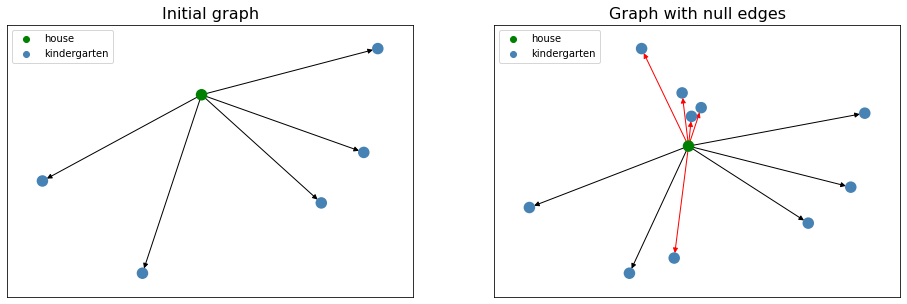

In [3]:
graph_example = nx.read_graphml("../23_10_22/data/kindergartens_model_2022_new.graphml", node_type=int)

draw_sparse_example(graph_example, house_node=126600)
plt.show()

In [2]:
class ProvisionSparseDataset(InMemoryDataset):
    def __init__(self, root, transform=None):
        super(ProvisionSparseDataset, self).__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        for file in os.listdir(self.root):
            if file.endswith(".graphml"):
                files.append(file)
        return files
        
    @property
    def processed_file_names(self):
        return ['../provision.dataset']

    def download(self):
        pass
    
    def process(self):

        null_edge_ratio = 4
        accessibility_normative = 300 

        # read distance matrix to build null edges with distance as weights
        with open(os.path.join(self.root, "distance_matrix.json")) as f:
            file = json.load(f)
            matrix = pd.read_json(file)

        data_list = []
        for file in self.raw_file_names:
            
            # read DIRECTED graph
            graph = nx.read_graphml(os.path.join(self.root, file), node_type=int)
            del graph.graph['node_default'], graph.graph['edge_default']
            
            for u, d in graph.nodes(data=True):
                obj_type = 1. if d["type"] == "house" else 0.
                initial_value = float(d["demand"]) if "demand" in d else float(d["capacity"])
                d.clear()
                d["x"] = [obj_type, initial_value]
                d["id"] = u

            for u, v, d in graph.edges(data=True):
                d["is_available"] = 1. if d["distance"] <= accessibility_normative else 0.
                d["y"] = d["load"]
                del d["load"]

            x = np.array([[i, d["x"][0], d["x"][1]] for i, d in graph.nodes(data=True)])
            edges = np.array([[u, v, d["y"], d["is_available"], d["distance"]] for u, v, d in graph.edges(data=True)])
            houses_id = x[:, 0][x[:, 1] == 1]
            services_id = x[:, 0][x[:, 1] == 0]

            # negative sampling - add random null edges to graph
            # the number of null edges is equal to len(edges) * null_edge_ratio
            null_edges = []
            for h_id in houses_id:
                connected_services = edges[:, 1][edges[:, 0] == h_id]
                remain_services = [s for s in services_id if s not in connected_services]
                for i in range(len(connected_services) * null_edge_ratio):
                    s_id = np.random.choice(remain_services)
                    distance = matrix[h_id][s_id]
                    available = 1. if distance <= accessibility_normative else 0.
                    null_edges.append([h_id, s_id, {"y": 0., "is_available": available, "distance": distance}])
                    remain_services.remove(s_id)
            graph.add_edges_from(null_edges)

            graph = pyg.utils.convert.from_networkx(graph, group_edge_attrs=["is_available", "distance"])
            graph.edge_attr = torch.tensor(graph.edge_attr.numpy(), dtype=torch.float32)

            # sort edge_index, edge_attr and y
            graph.edge_index, attr = pyg.utils.sort_edge_index(
                graph.edge_index, [graph.y, graph.edge_attr], graph.num_nodes, True
                )
            graph.y, graph.edge_attr = attr

            data_list.append(graph)
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

In [5]:
sparse_dataset = ProvisionSparseDataset("./sparse_graphs/")

### 1.2 Dense graphs
Dense graphs contain **ALL edges** (all positive and ALL negative), but include **a few objects** (~ 1 000 houses and ~ 100 services) since it's too expensive to train/test NN with huge dense graphs.

In [7]:
def draw_dense_example(G, house_node):

    node = house_node
    sample = G.edge_subgraph(G.edges(node))
    sample_copy = sample.copy()

    plt.figure(figsize=(8, 6))
    plt.title("Graph with null edges", size=16)
    nx.draw_networkx(
        sample_copy, 
        with_labels=False, 
        node_size=100,
        linewidths = 1.5,
        edge_color = ["red" if d["load"] == 0 else "black" for u,v,d in sample_copy.edges(data=True)],
        node_color = ["green" if d["type"] == "house" else "steelblue" for u, d in sample_copy.nodes(data=True)],
)
        
    for n in ["green", "steelblue"]:
        plt.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
    plt.legend(loc="upper left")

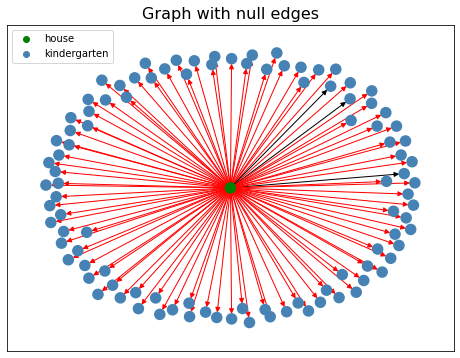

In [10]:
graph_example = nx.read_graphml("./dense_graphs/normarive_2030_greater_demand.graphml", node_type=int)

draw_dense_example(graph_example, house_node=114276)
plt.show()

In [6]:
class ProvisionDenseDataset(InMemoryDataset):
    def __init__(self, root, transform=None):
        super(ProvisionDenseDataset, self).__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        for file in os.listdir(self.root):
            if file.endswith(".graphml"):
                files.append(file)
        return files
        
    @property
    def processed_file_names(self):
        return ['../provision.dataset']

    def download(self):
        pass
    
    def process(self):

        accessibility_normative = 300 

        data_list = []
        for file in self.raw_file_names:
            
            # read DIRECTED graph
            graph = nx.read_graphml(os.path.join(self.root, file), node_type=int)
            del graph.graph['node_default'], graph.graph['edge_default']
            
            for u, d in graph.nodes(data=True):
                obj_type = 1. if d["type"] == "house" else 0.
                initial_value = float(d["demand"]) if "demand" in d else float(d["capacity"])
                coord = [d["x"], d["y"]]
                d.clear()
                
                d["x"] = [obj_type, initial_value]
                d["id"] = u
                d["coord"] = coord

            for u, v, d in graph.edges(data=True):
                d["is_available"] = 1. if d["distance"] <= accessibility_normative else 0.
                d["y"] = d["load"]
                del d["load"]
            
            graph = pyg.utils.convert.from_networkx(graph, group_edge_attrs=["is_available", "distance"])
            graph.edge_attr = torch.tensor(graph.edge_attr.numpy(), dtype=torch.float32)

            # sort edge_index, edge_attr and y
            graph.edge_index, attr = pyg.utils.sort_edge_index(
                graph.edge_index, [graph.y, graph.edge_attr], graph.num_nodes, True
                )
            graph.y, graph.edge_attr = attr

            data_list.append(graph)
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

In [7]:
dense_dataset = ProvisionDenseDataset("./dense_graphs/")

## 2. Model training

### 2.1 NN stack

First, **GNNConv** learns representation of each node using distance between house and service as edge weight, then there are two options that were tested:  
  
1. Concatenate only nodes' representation (house and connected service).  
2. Concatenate nodes' representation (house and connected service) and distance between them.  

*The second option allows to obtain the best results during training, but NN seems to learn really simple pattern that strongly depend on distance and might be predicted with the same accuracy using simpler models (e.g. gravity model - comparison is below*  

On the second step, **MLP** learns to predict population flow based on concatenated vectors. After the last layer, **normalization** is used to restrict the sum of population flow considering existing demand and capacity.  
  
$$
y_{norm_{i,j}} = min(  \frac{y_{i, j} * demand_{i}}{\sum_{i = 1}^{k}{y_{i, k}}}, \frac{y_{i, j} * capacity_{j}}{\sum_{i = 1}^{m}{y_{i, m}}}  )
$$

<p align="center">
  <img src="./img/normalization.png" />
</p>

Loss function - **MSE**, quality metrics - **R2, total error** (the total number of erroneously predicted people). 

In [8]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_conv_layers, dropout):
        super(GNNStack, self).__init__()

        self.mp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Dropout(dropout), 
            nn.Linear(hidden_dim, hidden_dim))

        self.convs = nn.ModuleList()
        self.num_conv_layers = num_conv_layers
        for l in range(self.num_conv_layers - 1):
            self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))
        self.convs.append(pyg_nn.GCNConv(hidden_dim, output_dim))

        self.lns = nn.ModuleList()
        for l in range(self.num_conv_layers - 1):
            self.lns.append(nn.LayerNorm(hidden_dim))

        self.dropout = dropout
        self.a = torch.nn.Parameter(torch.rand(1))
        self.b = torch.nn.Parameter(torch.rand(1))


    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, self.a / (data.edge_attr[:, 1] + 1) ** self.b

        x = self.mp(x)
        for i in range(self.num_conv_layers):
            x = self.convs[i](x, edge_index, edge_weight)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_conv_layers - 1:
                x = self.lns[i](x)

        return emb

class FlowPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(FlowPredictor, self).__init__()

        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_dim, hidden_dim))
        self.lins.append(nn.Linear(hidden_dim, output_dim))

        self.dropout = dropout
        self.a = torch.nn.Parameter(torch.rand(1))
        self.b = torch.nn.Parameter(torch.rand(1))

    def normalize(self, x, edge_index, y):

        y_sum_i = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y)
        y_norm_i = y * x[:, 1][edge_index[0, :]] / (y_sum_i[edge_index[0]] + 3.4028e-38)
        y_sum_j = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y)
        y_norm_j = y * x[:, 1][edge_index[1, :]] / (y_sum_j[edge_index[1]] + 3.4028e-38)

        return torch.min(y_norm_i, y_norm_j)

    def forward(self, emb, data):

        x, edge_index, edge_weight = data.x, data.edge_index, self.a / (data.edge_attr[:, 1] + 1) ** self.b

        emb_x_i = emb[edge_index[0]]
        emb_x_j = emb[edge_index[1]]
        coef = edge_weight.reshape(len(edge_weight), -1) 
        y = torch.cat((emb_x_i, emb_x_j, coef), dim=1)
        for lin in self.lins[:-1]:
            y = lin(y) 
            y = torch.relu(y)
            y = F.dropout(y, p=self.dropout, training=self.training)
        y = self.lins[-1](y)
        y = torch.relu(y).squeeze()
        y_norm = self.normalize(x, edge_index, y)  # normalize y based on house demand and kindergarten capacity
        return y_norm


### 2.2 Baseline: gravity model

In [9]:
class GravityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a =  torch.nn.Parameter(torch.rand(1)) # learnable parameter which needs to be estimated from the data
        self.b = torch.nn.Parameter(torch.rand(1)) # learnable parameter which takes into account the impact of distance
    
    def normalize(self, x, edge_index, y):

        y_sum_i = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y)
        y_norm_i = y * x[:, 1][edge_index[0, :]] / (y_sum_i[edge_index[0]] + 3.4028e-38)
        y_sum_j = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y)
        y_norm_j = y * x[:, 1][edge_index[1, :]] / (y_sum_j[edge_index[1]] + 3.4028e-38)
        return torch.min(y_norm_i, y_norm_j)
    
    def forward(self, data):

        demand = data.x[:, 1][data.edge_index[0]]
        capacity = data.x[:, 1][data.edge_index[1]]
        distance = data.edge_attr[:, 1] + 1
        y = self.a * demand * capacity / distance ** self.b
        y_norm = self.normalize(data.x, data.edge_index, y)
        return y_norm

### 2.3 Train / Valodation / Test strategy

**Training** with sparse graph, **validation** with small dense graph, **testing** with full dense graph.

1. *When null_edge_ratio is incrising up to 4, quality metrics go up.*
2. *When training is resumed with small dense graph, quality metrics go up.*

In [10]:
def train(epochs, train_dataset, valid_dataset, writer, model, checkpoints=None):

    input_dim_conv = 2
    hidden_dim_conv = 128
    output_dim_conv = 64
    num_conv_layers = 2

    link_hidden_dim = 128
    link_output_dim = 1
    num_linear_layer = 4

    dropout = 0.25

    # build model
    train_loader = DataLoader(train_dataset)

    if model == "NN":
        emb_model = GNNStack(input_dim_conv, hidden_dim_conv, output_dim_conv, num_conv_layers, dropout)
        flow_model = FlowPredictor(2 * output_dim_conv + 1, link_hidden_dim, link_output_dim, num_linear_layer, dropout)
        params = list(emb_model.parameters()) + list(flow_model.parameters())
        optimize = optim.Adam(params,  lr=0.01, weight_decay=10**-3)

    else:
        gravity_model = GravityModel()
        params = list(gravity_model.parameters())
        optimize = optim.Adam(list(gravity_model.parameters()),  lr=0.01)
        gravity_model.train()

    # train
    for epoch in range(epochs + 1):

        train_loss = []
        train_r2 = []
        for train_data in train_loader:
            optimize.zero_grad()

            # train NN model
            if model == "NN":

                # resume training if checkpoints were specified
                if checkpoints:
                    checkpoint = torch.load(checkpoints)
                    emb_model.load_state_dict(checkpoint['emb_model'])
                    flow_model.load_state_dict(checkpoint['flow_model'])
                    optimize.load_state_dict(checkpoint['optimizer'])

                emb_model.train()
                flow_model.train()
                embedding = emb_model(train_data)
                predict_y = flow_model(embedding, train_data)

            # 'train' gravity model to find coefficients based on observed data   
            else:
                gravity_model.train()
                predict_y = gravity_model(train_data)

            loss_function = torch.nn.MSELoss(reduction="mean")
            loss = loss_function(predict_y, train_data.y)
            train_loss.append(loss)
            train_r2.append(r2_loss(predict_y, train_data.y))

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(params, 1)
            optimize.step()
                
        train_r2 = sum(train_r2) / len(train_r2)
        train_loss = sum(train_loss) / len(train_loss)
        writer.add_scalar("train_loss", train_loss, epoch)
        writer.add_scalar("train_r2", train_r2, epoch)

        model_stack = [emb_model, flow_model] if model == "NN" else [gravity_model]

        if epoch % 5 == 0:
            q_metrics = validate(valid_dataset, model, model_stack)
            print(
                "Epoch {}. TRAIN: loss {:.4f}, r2: {:.4f}. VALIDATION loss: {:.4f}, standard deviation {:.4f}, r2: {:.4f}, total error {:.4f}."\
                    .format(epoch, train_loss, train_r2, q_metrics["test_loss"], q_metrics["std"], q_metrics["r2"], q_metrics["total_error"])
                )
            for name, q_metrics in q_metrics.items():
                writer.add_scalar(name, q_metrics, epoch)
    
    # save checkpoint to resume training later
    if model == "NN":
        save_ckp(epoch, emb_model, flow_model, optimize, f_path="./model")

    return model_stack


def validate(test_dataset, model, model_stack):

    if model == "NN":
        emb_model, flow_model = model_stack
        emb_model.eval()
        flow_model.eval()
    else:
        gravity_model = model_stack[0]
        gravity_model.eval()

    test_loader = DataLoader(test_dataset)

    test_loss = []
    test_r2 = []
    test_total_error = []
    test_std = []
    for test_data in test_loader:
        with torch.no_grad():

            if model == "NN":
                embedding = emb_model(test_data)
                predict_y = flow_model(embedding, test_data)
            else:
                predict_y = gravity_model(test_data)

            true_y = test_data.y
            test_loss.append(F.mse_loss(predict_y, test_data.y))
            test_r2.append(r2_loss(predict_y, true_y))
            test_total_error.append(torch.sum(torch.abs(true_y - predict_y)))
            test_std.append(torch.std(torch.abs(true_y - predict_y)))

    return {
        "test_loss": np.mean(test_loss), "r2": np.mean(test_r2), 
        "total_error": np.mean(test_total_error), "std": np.mean(test_std)
        }


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2


def save_ckp(epoch, emb_model, flow_model, optimizer, f_path):
    checkpoint = {
    'epoch': epoch + 1,
    'emb_model': emb_model.state_dict(),
    'flow_model': flow_model.state_dict(),
    'optimizer': optimizer.state_dict()
}
    f_path = os.path.join(f_path, 'checkpoint.pt')
    torch.save(checkpoint, f_path)

In [13]:
from tensorboardX import SummaryWriter
from datetime import datetime
writer = SummaryWriter("./logs/" + "NN-128-64-2-128-1-4-mse-decay-0001-resume")

In [23]:
sparse_dataset = sparse_dataset.shuffle()
emb_model, flow_model = train(50, sparse_dataset, dense_dataset, writer, model="NN")

Epoch 0. TRAIN: loss 84.1427, r2: 0.0179. VALIDATION loss: 3.0647, standard deviation 1.6703, r2: 0.0037, total error 28109.5918.
Epoch 5. TRAIN: loss 79.2656, r2: 0.0612. VALIDATION loss: 3.0647, standard deviation 1.6703, r2: 0.0037, total error 28113.8145.
Epoch 10. TRAIN: loss 78.2922, r2: 0.0739. VALIDATION loss: 3.0627, standard deviation 1.6693, r2: 0.0042, total error 28805.4531.
Epoch 15. TRAIN: loss 73.7082, r2: 0.1301. VALIDATION loss: 3.0626, standard deviation 1.6694, r2: 0.0042, total error 28742.1367.
Epoch 20. TRAIN: loss 68.3771, r2: 0.1931. VALIDATION loss: 3.0661, standard deviation 1.6710, r2: 0.0033, total error 27380.8555.
Epoch 25. TRAIN: loss 65.4848, r2: 0.2261. VALIDATION loss: 3.0658, standard deviation 1.6714, r2: 0.0034, total error 26342.9648.
Epoch 30. TRAIN: loss 44.8401, r2: 0.4736. VALIDATION loss: 3.0566, standard deviation 1.6684, r2: 0.0060, total error 27604.8691.
Epoch 35. TRAIN: loss 17.5603, r2: 0.7955. VALIDATION loss: 1.3339, standard deviatio

In [18]:
# Resume training with dense graph
dense_dataset = dense_dataset.shuffle()
emb_model, flow_model = train(50, dense_dataset[:5], dense_dataset[5:], writer, model="NN", checkpoints="./model/checkpoint.pt")

Epoch 0. TRAIN: loss 1.7290, r2: 0.4681. VALIDATION loss: 0.9528, standard deviation 0.9485, r2: 0.6180, total error 10480.4004.
Epoch 5. TRAIN: loss 1.6999, r2: 0.4714. VALIDATION loss: 0.9632, standard deviation 0.9536, r2: 0.6141, total error 10404.5078.
Epoch 10. TRAIN: loss 1.7140, r2: 0.4712. VALIDATION loss: 0.9648, standard deviation 0.9566, r2: 0.6104, total error 9721.7900.
Epoch 15. TRAIN: loss 1.7065, r2: 0.4757. VALIDATION loss: 0.9603, standard deviation 0.9538, r2: 0.6133, total error 9688.2842.
Epoch 20. TRAIN: loss 1.7154, r2: 0.4683. VALIDATION loss: 0.9393, standard deviation 0.9431, r2: 0.6211, total error 10365.5342.
Epoch 25. TRAIN: loss 1.7190, r2: 0.4693. VALIDATION loss: 0.9459, standard deviation 0.9460, r2: 0.6200, total error 10111.1592.
Epoch 30. TRAIN: loss 1.6953, r2: 0.4736. VALIDATION loss: 0.9680, standard deviation 0.9579, r2: 0.6097, total error 9751.9189.
Epoch 35. TRAIN: loss 1.7123, r2: 0.4732. VALIDATION loss: 0.9349, standard deviation 0.9406, r

In [12]:
sparse_dataset = sparse_dataset.shuffle()
gravity_model = train(50, sparse_dataset, dense_dataset, writer, model="gravity_model")[0]

Epoch 0. TRAIN: loss 27.9559, r2: 0.6712. VALIDATION loss: 2.9193, standard deviation 1.6315, r2: 0.0441, total error 29954.2344.
Epoch 5. TRAIN: loss 20.8566, r2: 0.7551. VALIDATION loss: 2.7976, standard deviation 1.5987, r2: 0.0800, total error 29360.7070.
Epoch 10. TRAIN: loss 20.0825, r2: 0.7641. VALIDATION loss: 2.7293, standard deviation 1.5798, r2: 0.1006, total error 28994.7266.
Epoch 15. TRAIN: loss 20.0603, r2: 0.7643. VALIDATION loss: 2.7132, standard deviation 1.5753, r2: 0.1055, total error 28905.0938.
Epoch 20. TRAIN: loss 20.0604, r2: 0.7643. VALIDATION loss: 2.7137, standard deviation 1.5755, r2: 0.1053, total error 28908.0176.
Epoch 25. TRAIN: loss 20.0601, r2: 0.7643. VALIDATION loss: 2.7154, standard deviation 1.5759, r2: 0.1048, total error 28917.1016.
Epoch 30. TRAIN: loss 20.0601, r2: 0.7643. VALIDATION loss: 2.7157, standard deviation 1.5760, r2: 0.1047, total error 28918.9844.
Epoch 35. TRAIN: loss 20.0601, r2: 0.7643. VALIDATION loss: 2.7156, standard deviatio

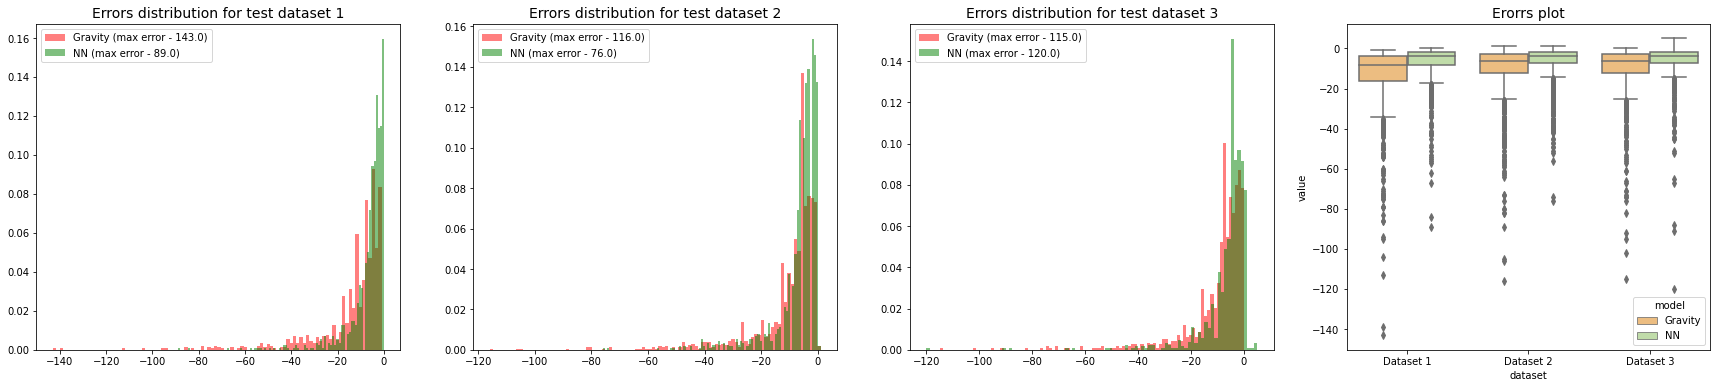

In [32]:
nn_errors = []
gravity_errors = []
for data in dense_dataset[3:]:
    with torch.no_grad():
        emb = emb_model(data)
        link = data.edge_index
        nn_predict_y = torch.round(flow_model(emb, data))

        pos_edges = data.y > 0
        nn_errors.append((nn_predict_y[pos_edges] - data.y[pos_edges]).tolist())

        gravity_predict_y = torch.round(gravity_model(data))
        gravity_errors.append((gravity_predict_y[pos_edges] - data.y[pos_edges]).tolist())


fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(30,6))
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True, linewidth=0.1)

ax0.set_title("Errors distribution for test dataset 1", size=14)
ax0.hist(gravity_errors[0], color="red", label=f'Gravity (max error - {max(np.abs(gravity_errors[0]))})', **kwargs)
ax0.hist(nn_errors[0], color="green", label=f'NN (max error - {max(np.abs(nn_errors[0]))})', **kwargs)
ax0.legend()

ax1.set_title("Errors distribution for test dataset 2", size=14)

ax1.hist(gravity_errors[1], color="red", label=f'Gravity (max error - {max(np.abs(gravity_errors[1]))})', **kwargs)
ax1.hist(nn_errors[1], color="green", label=f'NN (max error - {max(np.abs(nn_errors[1]))})', **kwargs)
ax1.legend()

ax2.set_title("Errors distribution for test dataset 3", size=14)
ax2.hist(gravity_errors[2], color="red", label=f'Gravity (max error - {max(np.abs(gravity_errors[2]))})', **kwargs)
ax2.hist(nn_errors[2], color="green", label=f'NN (max error - {max(np.abs(nn_errors[2]))})', **kwargs)
ax2.legend()

df_gravity = pd.DataFrame(
    [[val, f"Dataset {i + 1}", "Gravity"] for i in range(3) for val in gravity_errors[i]], 
    columns=["value", "dataset", "model"]
    )
df_nn = pd.DataFrame(
    [[val, f"Dataset {i + 1}", "NN"] for i in range(3) for val in nn_errors[i]], 
    columns=["value", "dataset", "model"]
    )
data_df = pd.concat([df_gravity, df_nn])
ax3.set_title('Erorrs plot', size=14)
sns.boxplot(data=data_df, x="dataset", y="value", hue="model", palette="Spectral")
  
plt.show()

## 3. Test on full dense graph

In [20]:
full_graph = torch.load("./test_data/full_dense_graph.pt")

In [19]:
def test(graph, model, model_stack):

    step = 300
    max_distant = torch.max(graph.edge_attr[:, 1]).item()

    iter_distances = [(0, step)]
    while iter_distances[-1][1] < max_distant:
        prev_distance = iter_distances[-1]
        iter_distances.append((prev_distance[1], prev_distance[1] * 2))


    graph.id_edge = torch.tensor(range(graph.num_edges), dtype=torch.long)
    data_bunch = Data(
        x=graph.x.clone(), 
        edge_index=torch.tensor([[],[]], dtype=torch.long), 
        edge_attr=torch.tensor([]),
        id_edge = torch.tensor([], dtype=torch.long)
        )

    predict_y = torch.tensor([])
    id_edge = torch.tensor([], dtype=torch.long)
    for min_dist, max_dist in tqdm(iter_distances):
        select = (full_graph.edge_attr[:, 1] >= min_dist) & (full_graph.edge_attr[:, 1] < max_dist) 

        data_bunch.edge_index = full_graph.edge_index[:, select]
        data_bunch.edge_attr = full_graph.edge_attr[select]
        data_bunch.id_edge = full_graph.id_edge[select]

        with torch.no_grad():

            if model == "NN":
                emb_model, flow_model = model_stack
                emb = emb_model(data_bunch)
                y = flow_model(emb, data_bunch)

            else:
                gravity_model = model_stack[0]
                y = gravity_model(data_bunch)
        y = torch.floor(y)
        demand_limit = torch.zeros_like(data_bunch.x[:, 1], dtype=y.dtype).index_add_(0, data_bunch.edge_index[0], y)
        capacity_limit = torch.zeros_like(data_bunch.x[:, 1], dtype=y.dtype).index_add_(0, data_bunch.edge_index[1], y)
        data_bunch.x[:, 1] = torch.round(data_bunch.x[:, 1] - capacity_limit - demand_limit)

        predict_y = torch.cat((predict_y, y))
        id_edge = torch.cat((id_edge, data_bunch.id_edge))

    return predict_y[torch.sort(id_edge)[1]]

In [21]:
with torch.no_grad():
    pos_edges = full_graph.y > 0

    nn_predict_y = test(full_graph, "NN", [emb_model, flow_model])
    nn_errors = (torch.round(nn_predict_y[pos_edges]) - full_graph.y[pos_edges]).tolist()

    gravity_predict_y = test(full_graph, "gravity_model", [gravity_model])
    gravity_errors = (torch.round(gravity_predict_y[pos_edges]) -full_graph.y[pos_edges]).tolist()

100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


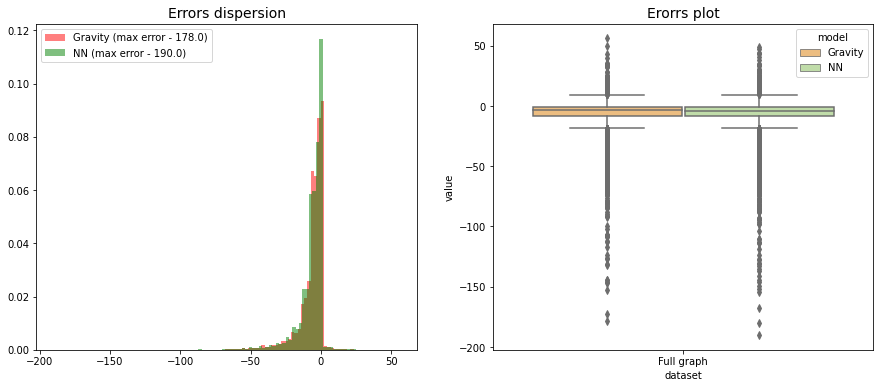

In [93]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,6))
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True, linewidth=0.1)

ax0.set_title("Errors dispersion", size=14)
ax0.hist(gravity_errors, color="red", label=f'Gravity (max error - {max(np.abs(gravity_errors))})', **kwargs)
ax0.hist(nn_errors, color="green", label=f'NN (max error - {max(np.abs(nn_errors))})', **kwargs)
ax0.legend()

df_gravity = pd.DataFrame(
    [[val, f"Full graph", "Gravity"] for val in gravity_errors], 
    columns=["value", "dataset", "model"]
    )
df_nn = pd.DataFrame(
    [[val, f"Full graph", "NN"] for val in nn_errors], 
    columns=["value", "dataset", "model"]
    )

data_df = pd.concat([df_gravity, df_nn])
ax1.set_title('Erorrs plot', size=14)
sns.boxplot(data=data_df, x="dataset", y="value", hue="model", palette="Spectral")

plt.show()

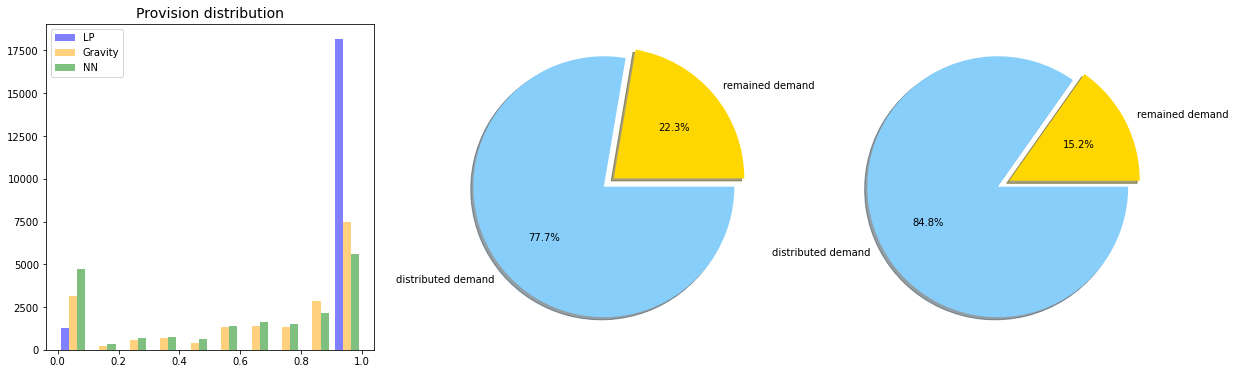

In [123]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,6))

select = (full_graph.x[:, 1]) > 0 & (full_graph.x[:, 0] == 1)

zero = torch.zeros_like(full_graph.x[:, 1], dtype=full_graph.y.dtype)
nn_y_sum = zero.index_add_(0, full_graph.edge_index[0], nn_predict_y)
df_nn = pd.DataFrame(nn_y_sum[select] / full_graph.x[:, 1][select], columns=["provision"])
df_nn["model"] = "NN"

zero = torch.zeros_like(full_graph.x[:, 1], dtype=full_graph.y.dtype)
gravity_y_sum = zero.index_add_(0, full_graph.edge_index[0], gravity_predict_y)
gravity_df = pd.DataFrame(torch.round(gravity_y_sum[select]) / full_graph.x[:, 1][select], columns=["provision"])
gravity_df["model"] = "Gravity"

zero = torch.zeros_like(full_graph.x[:, 1], dtype=full_graph.y.dtype)
true_y_sum= zero.index_add_(0, full_graph.edge_index[0], full_graph.y)
true_df = pd.DataFrame(torch.round(true_y_sum[select]) / full_graph.x[:, 1][select], columns=["provision"])
true_df["model"] = "True"

ax0.set_title("Provision distribution", size=14)
ax0.hist(
    (true_df["provision"], gravity_df["provision"], df_nn["provision"]), 
    label = ["LP", "Gravity", "NN"],
    color=["blue", "orange", "green"], 
    alpha=0.5)
ax0.legend()

ax1.pie(
    [torch.sum(full_graph.y) - torch.sum(nn_predict_y), torch.sum(nn_predict_y)],
    explode=[0.1, 0],
    labels = ["remained demand", "distributed demand"],
    colors = ['gold', 'lightskyblue'],
    autopct='%1.1f%%',
    shadow=True)

ax2.pie(
    [torch.sum(full_graph.y) - torch.sum(gravity_predict_y), torch.sum(gravity_predict_y)],
    explode=[0.1, 0],
    labels = ["remained demand", "distributed demand"],
    colors = ['gold', 'lightskyblue'],
    autopct='%1.1f%%',
    shadow=True)
plt.show()

In [ ]:
def data_to_geojson(data):
    pass

In [127]:
dense_dataset[0]

Data(x=[1100, 2], edge_index=[2, 100000], y=[100000], id=[1100], coord=[1100, 2], is_avalible=[100000], edge_attr=[100000, 2])